# Assignment 1: Review Recommendations

**Sam Lau, PID A11180904, sel011@ucsd.edu**

In [1]:
import warnings 

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datascience import *
from pprint import pprint
import re
sns.set()
sns.set_context('poster')
import random
import os
# from tqdm import tqdm as t

from IPython.display import display, Latex, Markdown, HTML
import ipywidgets as widgets
from ipywidgets import interact
import nbinteract as nbi
pd.options.display.max_rows = 5

In [2]:
import toolz.curried as tz
from tqdm import tqdm as t

## Loading the data

In [3]:
ls data/

baselines.py        pairs_Purchase.txt  test_Category.json  train.json
pairs_Category.txt  pairs_Rating.txt    train.csv


In [115]:
from ast import literal_eval
all_train = pd.read_csv('data/train.csv')
all_train['categories'] = all_train['categories'].apply(literal_eval)
all_train

,categories,categoryID,helpful,itemID,price,rating,reviewHash,reviewText,reviewTime,reviewerID,summary,unixReviewTime
0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",0,"{'nHelpful': 0, 'outOf': 0}",I402344648,NaN,4.0,R798569390,The model in this picture has them rolled up a...,"09 26, 2013",U490934656,High Waisted,1380153600
1,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",0,"{'nHelpful': 0, 'outOf': 0}",I697650540,NaN,4.0,R436443063,"I love the look of this bra, it is what I want...","02 7, 2013",U714157797,Beautiful but size runs small,1360195200
...,...,...,...,...,...,...,...,...,...,...,...,...
199998,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",0,"{'nHelpful': 0, 'outOf': 1}",I343675670,7.5,5.0,R524991477,My granddaughter love the scarf and fit perfec...,"12 27, 2013",U995566285,Scarf,1388102400
199999,"[[Clothing, Shoes & Jewelry, Baby, Baby Girls,...",4,"{'nHelpful': 1, 'outOf': 2}",I757871532,NaN,1.0,R695913313,My baby wore it only one time and there are ho...,"03 1, 2014",U994496485,Very bad!,1393632000


## Task 1: Purchase Predictions

In [5]:
users = all_train['reviewerID'].unique()
items = all_train['itemID'].unique()
user_item_pairs = set(all_train[['reviewerID', 'itemID']]
                      .itertuples(index=False, name=None))

len(users), len(items), len(user_item_pairs)

(39239, 19914, 200000)

In [6]:
np.random.seed(42)

pick_one = np.random.choice

def pick_user_item():
    while True:
        yield (pick_one(users), pick_one(items))

def is_reviewed(pair):
    return pair in user_item_pairs

unseen_pairs = tz.pipe(
    pick_user_item(),
    tz.remove(is_reviewed),
    tz.take(100_000),
    list
)

len(unseen_pairs)

100000

,categories
itemID,
I000024906,"[[Clothing, Shoes & Jewelry, Women, Accessorie..."
I000030838,"[[Sports & Outdoors, Accessories, Sport Watche..."
...,...
I999879552,"[[Clothing, Shoes & Jewelry, Women, Shoes, San..."
I999917660,"[[Clothing, Shoes & Jewelry, Women], [Clothing..."


In [145]:
seen = all_train[['reviewerID', 'itemID']].assign(reviewed=1)
unseen = (pd.DataFrame(unseen_pairs, columns=['reviewerID', 'itemID'])
          .assign(reviewed=0))
train_and_valid = pd.concat([seen, unseen], ignore_index=True)
train_and_valid

,reviewerID,itemID,reviewed
0,U490934656,I402344648,1
1,U714157797,I697650540,1
...,...,...,...
299998,U357509274,I577669367,0
299999,U338076942,I613217570,0


In [150]:
np.random.seed(42)

indices = np.random.choice(len(train_and_valid),
                           size=len(train_and_valid), replace=False)

train = train_and_valid.iloc[indices[:150000]]
valid = train_and_valid.iloc[indices[150000:]]
train

,reviewerID,itemID,reviewed
4941,U834494147,I128611472,1
51775,U461858851,I234579649,1
...,...,...,...
31286,U659379356,I164073413,1
205716,U650550285,I701742363,0


In [128]:
item_categories = all_train.groupby('itemID')['categories'].first().to_frame()
item_categories

,categories
itemID,
I000024906,"[[Clothing, Shoes & Jewelry, Women, Accessorie..."
I000030838,"[[Sports & Outdoors, Accessories, Sport Watche..."
...,...
I999879552,"[[Clothing, Shoes & Jewelry, Women, Shoes, San..."
I999917660,"[[Clothing, Shoes & Jewelry, Women], [Clothing..."


In [160]:
def category_set(categories: 'Series([list])'):
    return {tuple(category) for category in categories}

def make_category_map(df, key):
    return (
        df[df['reviewed'] == 1]
        .merge(item_categories, left_on='itemID', right_index=True, how='left')
        .groupby(key)
        ['categories']
        .sum()
        .apply(category_set)
    )

user_map = make_category_map(train, 'reviewerID')
user_map

reviewerID
U000005569    {(Clothing, Shoes & Jewelry, Jewelry Outlet), ...
U000024709    {(Clothing, Shoes & Jewelry, Women, Shoes, Boo...
                                    ...                        
U999919996    {(Clothing, Shoes & Jewelry, Women, Jewelry, R...
U999927096    {(Clothing, Shoes & Jewelry, Women, Clothing, ...
Name: categories, Length: 36447, dtype: object

In [161]:
item_map = make_category_map(train, 'itemID')
item_map

itemID
I000024906    {(Clothing, Shoes & Jewelry, Women, Accessorie...
I000030838    {(Clothing, Shoes & Jewelry, Men), (Clothing, ...
                                    ...                        
I999879552    {(Clothing, Shoes & Jewelry, Women, Shoes, San...
I999917660    {(Clothing, Shoes & Jewelry, Women), (Clothing...
Name: categories, Length: 19414, dtype: object

In [192]:
from itertools import product

def jaccard(s1, s2):
    s1, s2 = set(s1), set(s2)
    return len(s1 & s2) / len(s1 | s2)

def max_pairwise_jaccard(sets_pair):
    sets1, sets2 = sets_pair
    if isinstance(sets1, float) or isinstance(sets2, float):
        return 0
    pairs = product(sets1, sets2)
    return max(jaccard(s1, s2) for s1, s2 in pairs)

max_pairwise_jaccard((user_map['U490934656'], item_map['I402344648']))

1.0

In [193]:
with_categories = (train.merge(
    user_map.to_frame(), left_on='reviewerID', right_index=True,
    how='left', validate='m:1'
).merge(
    item_map.to_frame(), left_on='itemID', right_index=True,
    how='left', validate='m:1', suffixes=['_reviewer', '_item']
))
with_categories

,reviewerID,itemID,reviewed,categories_reviewer,categories_item
4941,U834494147,I128611472,1,"{(Clothing, Shoes & Jewelry, Men, Big & Tall),...","{(Clothing, Shoes & Jewelry, Men, Big & Tall),..."
51775,U461858851,I234579649,1,"{(Clothing, Shoes & Jewelry, Women, Clothing, ...","{(Clothing, Shoes & Jewelry, Women, Clothing, ..."
...,...,...,...,...,...
31286,U659379356,I164073413,1,"{(Clothing, Shoes & Jewelry, Women, Shoes, San...","{(Clothing, Shoes & Jewelry, Women, Clothing, ..."
205716,U650550285,I701742363,0,"{(Clothing, Shoes & Jewelry, Women, Shoes, Loa...","{(Clothing, Shoes & Jewelry, Winter Promo), (C..."


In [196]:
%%time

sims = (with_categories[['categories_reviewer', 'categories_item']]
 .apply(max_pairwise_jaccard, axis=1)
)
with_categories = with_categories.assign(sims=sims)

CPU times: user 9.25 s, sys: 64.6 ms, total: 9.32 s
Wall time: 9.45 s


In [197]:
with_categories

,reviewerID,itemID,reviewed,categories_reviewer,categories_item,sims
4941,U834494147,I128611472,1,"{(Clothing, Shoes & Jewelry, Men, Big & Tall),...","{(Clothing, Shoes & Jewelry, Men, Big & Tall),...",1.0
51775,U461858851,I234579649,1,"{(Clothing, Shoes & Jewelry, Women, Clothing, ...","{(Clothing, Shoes & Jewelry, Women, Clothing, ...",1.0
...,...,...,...,...,...,...
31286,U659379356,I164073413,1,"{(Clothing, Shoes & Jewelry, Women, Shoes, San...","{(Clothing, Shoes & Jewelry, Women, Clothing, ...",1.0
205716,U650550285,I701742363,0,"{(Clothing, Shoes & Jewelry, Women, Shoes, Loa...","{(Clothing, Shoes & Jewelry, Winter Promo), (C...",1.0


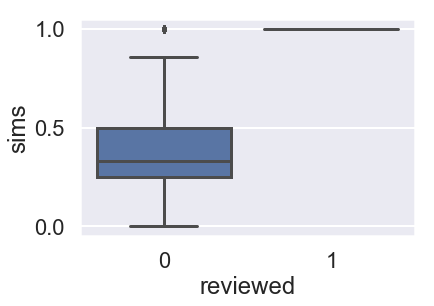

In [202]:
sns.boxplot(x='reviewed', y='sims', data=with_categories)

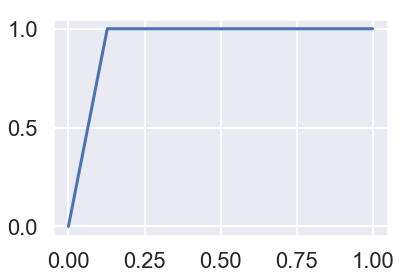

In [204]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = (
    roc_curve(with_categories['reviewed'], with_categories['sims'])
)
plt.plot(fpr, tpr)

In [244]:
def has_shared_category(series):
    item_cat, user_cat = series
    return (0 if any(series.isna())
            else int(len(item_cat & user_cat) > 0))

In [264]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

sim_map = {
    'has_shared_category': has_shared_category,
    'max_pairwise_jaccard': max_pairwise_jaccard,
}

class CategorySimRec(BaseEstimator, ClassifierMixin):
    def __init__(self, cutoff=0.5, sim='max_pairwise_jaccard'):
        self.cutoff = cutoff
        self.sim = sim
        
    def fit(self, X, y=None):
        self.X_ = X
        self.y_ = y
        
        self.user_map_ = make_category_map(X, 'reviewerID')
        self.item_map_ = make_category_map(X, 'itemID')
        return self
        
    def predict_proba(self, X):
        check_is_fitted(self, ['X_', 'user_map_', 'item_map_'])
        return (
            X.merge(self.user_map_.to_frame(),
                    left_on='reviewerID', right_index=True, how='left',
                    validate='m:1')
            .merge(self.item_map_.to_frame(),left_on='itemID',
                   right_index=True, how='left', validate='m:1',
                   suffixes=['_reviewer', '_item'])
            [['categories_reviewer', 'categories_item']]
            .apply(sim_map[self.sim], axis=1)
        )
        
    def predict(self, X):
        return (self.predict_proba(X) >= self.cutoff).astype(int)

In [273]:
%%time

from sklearn.model_selection import GridSearchCV

grid = {
    'sim': ['has_shared_category']
}

clf = GridSearchCV(CategorySimRec(), param_grid=grid, n_jobs=3)
clf.fit(train_and_valid, train_and_valid['reviewed'])
print(clf)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=CategorySimRec(cutoff=0.5, sim='max_pairwise_jaccard'),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'sim': ['has_shared_category']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
CPU times: user 21.9 s, sys: 3.43 s, total: 25.3 s
Wall time: 2min 16s


In [274]:
clf.best_params_

{'sim': 'has_shared_category'}

In [275]:
clf.predict(train[0:5])

4941      1
51775     1
115253    1
299321    0
173570    1
dtype: int64

In [276]:
clf.score(valid[0:100], valid['reviewed'][0:100])

0.98

**Make test predictions**

In [277]:
test = pd.read_csv('data/pairs_Purchase.txt')
split = (
    test['reviewerID-itemID'].str.split('-', expand=True)
    .rename(columns={0: 'reviewerID', 1: 'itemID'})
)
split

,reviewerID,itemID
0,U938994110,I529819131
1,U181459539,I863471064
...,...,...
27998,U566804667,I857242737
27999,U691248665,I871166941


In [278]:
predictions = clf.predict(split)
predictions[:5]

0    1
1    0
2    0
3    0
4    1
dtype: int64

In [279]:
(test.assign(prediction=predictions)
 .to_csv('purchase_pred.csv', index=False)
)

In [280]:
!head purchase_pred.csv

reviewerID-itemID,prediction
U938994110-I529819131,1
U181459539-I863471064,0
U941668816-I684585522,0
U768449391-I782253949,0
U640450168-I232683472,1
U087574132-I014281144,1
U885457860-I600866492,0
U319023404-I050733439,0
U535965656-I929867818,1


## Task 2